pandas.groupby的官方示例

In [3]:
import numpy as np
import pandas as pd

groupby对象的常见操作：
（1）利用agg/aggragate进行聚合操作，对每个group内的数据返回一个标量值，常用来统计sie、count，或计算统计量sum、mean等
（2）利用transform进行函数变换，返回一个和原group同shape的数据，常用来进行组内的标准化，或用每组内的统计量进行Nan值的填充
（3）利用filter进行过滤操作，将每个组作为一个整体对象进行判断，返回True或False。重用于基于组内数据个数或统计量，对整组进行discard
（4）利用apply，更加弹性

#### 1. groupby对象

In [4]:
df = pd.DataFrame([('bird', 'Falconiformes', 389.0), ('bird', 'Psittaciformes', 24.0),
('mammal', 'Carnivora', 80.2), ('mammal', 'Primates', np.nan), ('mammal', 'Carnivora', 58)],
index=['falcon', 'parrot', 'lion', 'monkey', 'leopard'], columns=('class', 'order', 'max_speed'))

In [5]:
df.groupby('class')

In [6]:
df.groupby('class', axis='columns')

In [8]:
df.groupby(['class', 'order'])

#### 2. 重复index的groupby

In [9]:
lst = [1, 2, 3, 1, 2, 3]
s = pd.Series([1, 2, 3, 10, 20, 30], lst)
s

1     1
2     2
3     3
1    10
2    20
3    30
dtype: int64

In [11]:
grouped = s.groupby(level=0)

In [12]:
grouped.first()

1    1
2    2
3    3
dtype: int64

In [13]:
grouped.last()

1    10
2    20
3    30
dtype: int64

In [16]:
grouped.sum()

1    11
2    22
3    33
dtype: int64

#### 3. 获取分组后个别组的信息

In [17]:
df3 = pd.DataFrame({'X': ['A', 'B', 'A', 'B'], 'Y': [1, 4, 3, 2]})

In [18]:
df3.groupby(['X']).get_group('A')

,X,Y
0,A,1
2,A,3


In [19]:
df3.groupby(['X']).get_group('B')

,X,Y
1,B,4
3,B,2


#### 4. 可视化groupby之后的groups

In [20]:
df3.groupby(['X']).groups

{'A': Int64Index([0, 2], dtype='int64'),
 'B': Int64Index([1, 3], dtype='int64')}

In [21]:
df.groupby(['class', 'order']).groups

{('bird', 'Falconiformes'): Index(['falcon'], dtype='object'),
 ('bird', 'Psittaciformes'): Index(['parrot'], dtype='object'),
 ('mammal', 'Carnivora'): Index(['lion', 'leopard'], dtype='object'),
 ('mammal', 'Primates'): Index(['monkey'], dtype='object')}

#### 5. 多层index的groupby

In [22]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
s = pd.Series(np.random.randn(8), index=index)
s

first  second
bar    one      -1.983934
       two      -0.401538
baz    one      -0.551952
       two       1.465394
foo    one      -0.870943
       two       0.153282
qux    one      -0.478329
       two       0.162105
dtype: float64

In [23]:
grouped = s.groupby(level=0)
grouped.sum()

first
bar   -2.385472
baz    0.913442
foo   -0.717661
qux   -0.316224
dtype: float64

In [24]:
# 根据第二个index进行group后再排序
s.groupby(level='second').sum()

second
one   -3.885159
two    1.379243
dtype: float64

In [25]:
# 对于sum等聚合操作，可以直接设定level参数
s.sum(level='second')

second
one   -3.885159
two    1.379243
dtype: float64

#### 6. 同时按照index和column进行groupby

In [26]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
df = pd.DataFrame({'A': [1, 1, 1, 1, 2, 2, 3, 3], 'B': np.arange(8)}, index=index)
df

A  B
first second      
bar   one     1  0
      two     1  1
baz   one     1  2
      two     1  3
foo   one     2  4
      two     2  5
qux   one     3  6
      two     3  7

In [27]:
# column直接采用名称，index通过pd.Grouper对象封装
df.groupby([pd.Grouper(level=1), 'A']).sum()   # 第二个index

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

In [28]:
# index可以直接通过name指定
df.groupby([pd.Grouper(level='second'), 'A']).sum()

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

In [29]:
# index也可以直接指定
df.groupby(['second', 'A']).sum()

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

#### 7. groups的迭代

In [31]:
for name, group in df.groupby('first'):
    print(name)
    print(group)

bar
              A  B
first second      
bar   one     1  0
      two     1  1
baz
              A  B
first second      
baz   one     1  2
      two     1  3
foo
              A  B
first second      
foo   one     2  4
      two     2  5
qux
              A  B
first second      
qux   one     3  6
      two     3  7


#### 8.groupby组内的transformation运算

In [40]:
index = pd.date_range('10/1/1999', periods=1100)
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)
ts.head()

1999-10-01    0.872901
1999-10-02    2.376990
1999-10-03    1.225526
1999-10-04    1.106265
1999-10-05    0.713613
Freq: D, dtype: float64

In [49]:
# 利用时间窗进行序列的平滑
ts = ts.rolling(window=100, min_periods=100).mean().dropna()
ts.head()

2000-01-08    0.513313
2000-01-09    0.503742
2000-01-10    0.476918
2000-01-11    0.470249
2000-01-12    0.444003
Freq: D, dtype: float64

In [50]:
transformed = (ts.groupby(lambda x: x.year).transform(lambda x: (x - x.mean()) / x.std()))

In [52]:
# 原数据的平均值统计
grouped = ts.groupby(lambda x: x.year)
print(grouped.mean())
print("---"*5)
print(grouped.std())

2000    0.611221
2001    0.460703
2002    0.489024
dtype: float64
---------------
2000    0.158965
2001    0.169955
2002    0.102585
dtype: float64


In [53]:
# transform之后的平均值统计
grouped_trans = transformed.groupby(lambda x: x.year)
print(grouped_trans.mean())
print("---"*5)
print(grouped_trans.std())

2000   -2.195396e-15
2001   -1.818637e-15
2002   -6.031076e-16
dtype: float64
---------------
2000    1.0
2001    1.0
2002    1.0
dtype: float64


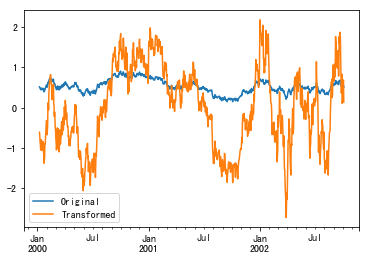

In [56]:
# 比较transform前后的数据变化
import matplotlib.pyplot as plt
compare = pd.DataFrame({'Original': ts, 'Transformed': transformed})
compare.plot()
plt.show()

#### 9. groupby组内的过滤操作

In [57]:
# 统计组内数据和大于2的数据
sf = pd.Series([1, 1, 2, 3, 3, 3])
sf.groupby(sf).filter(lambda x: x.sum() > 2)

3    3
4    3
5    3
dtype: int64

In [58]:
# 统计组内数据量大于2的数据
dff = pd.DataFrame({'A': np.arange(8), 'B': list('aabbbbcc')})
dff.groupby('B').filter(lambda x: len(x) > 2)

,A,B
2,2,b
3,3,b
4,4,b
5,5,b


In [59]:
# 统计组内数据量大于2的数据，不满足的用NaN填充
dff.groupby('B').filter(lambda x: len(x) > 2, dropna=False)

,A,B
0,NaN,NaN
1,NaN,NaN
2,2.0,b
3,3.0,b
4,4.0,b
5,5.0,b
6,NaN,NaN
7,NaN,NaN


#### 10 组内的n个最大和最小值

In [61]:
s = pd.Series([9, 8, 7, 5, 19, 1, 4.2, 3.3])
g = pd.Series(list('abababab'))
gb = s.groupby(g)

In [62]:
# 每组最大的三个值
gb.nlargest(3)

a  4    19.0
   0     9.0
   2     7.0
b  1     8.0
   3     5.0
   7     3.3
dtype: float64

In [63]:
# 每组最小的三个值b吗
gb.nsmallest(3)

a  6    4.2
   2    7.0
   0    9.0
b  5    1.0
   7    3.3
   3    5.0
dtype: float64

#### 11. 分组后的apply

In [65]:
df.groupby('second').apply(lambda x: x.describe())

A         B
second                          
one    count  4.000000  4.000000
       mean   1.750000  3.000000
       std    0.957427  2.581989
       min    1.000000  0.000000
       25%    1.000000  1.500000
       50%    1.500000  3.000000
       75%    2.250000  4.500000
       max    3.000000  6.000000
two    count  4.000000  4.000000
       mean   1.750000  4.000000
       std    0.957427  2.581989
       min    1.000000  1.000000
       25%    1.000000  2.500000
       50%    1.500000  4.000000
       75%    2.250000  5.500000
       max    3.000000  7.000000